In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats

np.random.seed(27);
torch.manual_seed(27);

In [2]:
DEVICE = 'cuda'

## Torus model

In [3]:
def model(v, center = np.array([0.6, 0.8])):
    a, b, c = v
    r = ((a-center[0])**2+(b-center[1])**2)**0.5  # Return radial distance from center
    x = np.array([a, r, c])
    return dict(x=x)

def noise(obs, v, noise = np.array([0.03, 0.005, 0.2])):
    x = obs['x']
    n = np.random.randn(*x.shape)*noise
    return dict(x = x + n)

In [4]:
v0 = np.array([0.57, 0.8, 1.0])
obs0 = model(v0)  # Using Asimov data

In [5]:
prior = swyft.Prior.from_uv(lambda u: u, 3)

In [6]:
simulator = swyft.Simulator(model, sim_shapes = dict(x=(3,)))
store = swyft.MemoryStore(3, simulator = simulator)

In [7]:
partitions = [0, 1, 2]
micro = swyft.Microscope(partitions, prior, obs0, store = store, simhook = noise, device = DEVICE)
micro.focus(max_rounds=5)

In [8]:
post = swyft.Posteriors.from_Microscope(micro)
post.infer([(0, 1), (0, 2), (1, 2)], device = DEVICE)

In [9]:
samples = post.sample(1000000, obs0)

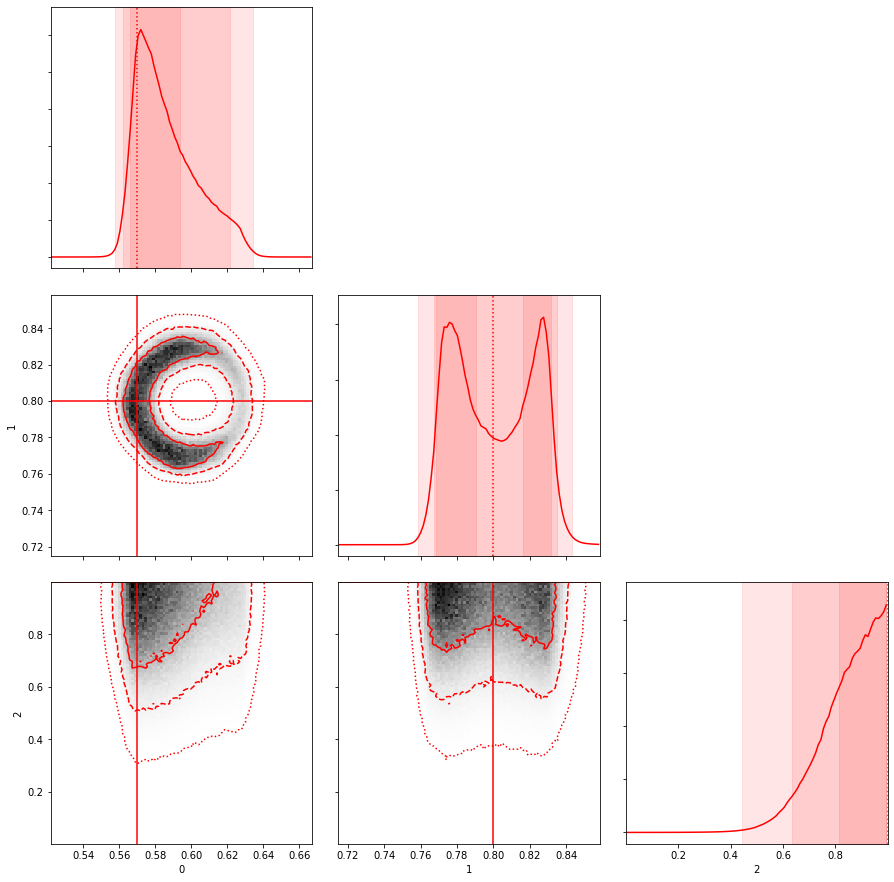

In [10]:
swyft.corner(samples, [0, 1, 2], color='r', figsize = (15,15), truth=v0)

In [11]:
len(store)

29040